# Problem set 3: DQN, Policy gradient and its variants

**Due: 11:59pm, November 2, 2025**

In the last PSET of reinforcement learning, you will implement the DQN algorithm together with vanilla policy gradient (REINFORCE) and its variants. In the last problem you will train a half-cheetah with stable baseline 3 package. 

- Problem 1 requires implementing DQN and double DQN. **TODOs:**
  
  - 1.1 Finish vanilla DQN (20 pt)
  - 1.2 Finish double DQN (5 pt)

- Problem 2 verify the policy gradient theory and requires implementing REINFORCE with learned value function. **TODOs:**
  
  - 2.1 Verify different policy gradient estimator (15 pt)
  - 2.2 Implement REINFORCE with learned baseline (10 pt)

- Problem 3 requires implementing vanilla on-policy actor-critic algorithm. **TODOs:**
  - 3.1 Implement vanilla actor-critic (25 pt)

All of these three algorithms works on `gym`'s `Acrobot-v1` environments.

- Problem 4 requires implementing PPO algorithm. **TODOs:**
  - 4.1 Implement PPO-cliping (25 pt)

- Problem 5 **(Bonus)** help you try stable baseline 3 on `gym`'s `Half-cheetah-v4` environment. **TODOs:**
  - 5.1 Tune the parameter in stable baseline 3 (**Note the training can take 15 min**) (20 pt)
  

## Problem 1: DQN

In this problem you will implement DQN on `Acrobot-v1` environment using `gym`.

### Algorithm recap

1. **Q-network**
   - Function approximator $Q_\theta(s,a)$ for action values (here: a small MLP).

2. **Target network**
   - A copy of the online network with parameters $\theta^-$ that are updates periodically to stabilize training.

3. **Experience replay**
   - A replay buffer of transitions $(s,a,r,s',\text{done})$. Sample i.i.d. minibatches to break temporal correlations.

4. **Behavior policy**
   - $\epsilon$-greedy: with probability $\epsilon$ choose a random action; otherwise choose $ \arg\max_a Q_\theta(s,a) $.

5. **TD targets**
   - **Standard DQN**:
     $$
     y = r + \gamma \max_{a'} Q_{\theta^-}(s', a')
     $$
   - **Double DQN**:
     $$
     a^\star = \arg\max_{a'} Q_{\theta}(s', a'), \quad
     y = r + \gamma \, Q_{\theta^-}(s', a^\star)
     $$
     “Online net selects, target net evaluates” reduces overestimation. In comparison to Double Q-learning, the weights of the second network $\theta$ are replaced with the weights of the target network $\theta^−$ for the evaluation of the current greedy policy. The update to the target network stays unchanged from DQN, and remains a periodic copy of the online network.

6. **Loss & optimization**
   - Regress $Q_\theta(s,a)$ to target $y$ using MSE loss; backpropagate to update $\theta$.

### Environment & action space

- **Env**: `Acrobot-v1` (double pendulum swing-up) [Link](https://gymnasium.farama.org/environments/classic_control/acrobot/)
- **Observation**: 6D —- $\cos\theta_1, \sin\theta_1, \cos\theta_2, \sin\theta_2, \dot\theta_1, \dot\theta_2$  
- **Actions**: Discrete 3 actions —- torques $-1, 0, +1$  
- **Reward**: $-1$ per step until the goal is reached (or the episode times out)


### 1.1 Implement DQN with gym

**TODO:** Fill in the three TODO blocks.
- implement a simple MLP
- implement the replaybuffer class
- implement the main algorithm

All the given code is for reference. If you find it inconvenient feel free to write yourself.

Note the final average return should be around $-100$.

[Env] Acrobot-v1 | obs_dim=6, n_actions=3
[DDQN]  Ep   10 | Return  -500.00 | eps=0.953 | steps=5000
[DDQN]  Ep   20 | Return  -500.00 | eps=0.907 | steps=9814
[DDQN]  Ep   30 | Return  -374.00 | eps=0.863 | steps=14422
[DDQN]  Ep   40 | Return  -500.00 | eps=0.818 | steps=19143
[DDQN]  Ep   50 | Return  -500.00 | eps=0.772 | steps=24000
[DDQN]  Ep   60 | Return  -444.00 | eps=0.726 | steps=28883
[DDQN]  Ep   70 | Return  -500.00 | eps=0.680 | steps=33678
[DDQN]  Ep   80 | Return  -500.00 | eps=0.636 | steps=38337
[DDQN]  Ep   90 | Return  -500.00 | eps=0.590 | steps=43191
[DDQN]  Ep  100 | Return  -500.00 | eps=0.545 | steps=47931
[DDQN]  Ep  110 | Return  -500.00 | eps=0.497 | steps=52908
[DDQN]  Ep  120 | Return  -500.00 | eps=0.451 | steps=57768
[DDQN]  Ep  130 | Return  -500.00 | eps=0.405 | steps=62643
[DDQN]  Ep  140 | Return  -352.00 | eps=0.363 | steps=67054
[DDQN]  Ep  150 | Return  -269.00 | eps=0.325 | steps=71005
[DDQN]  Ep  160 | Return  -304.00 | eps=0.286 | steps=75149


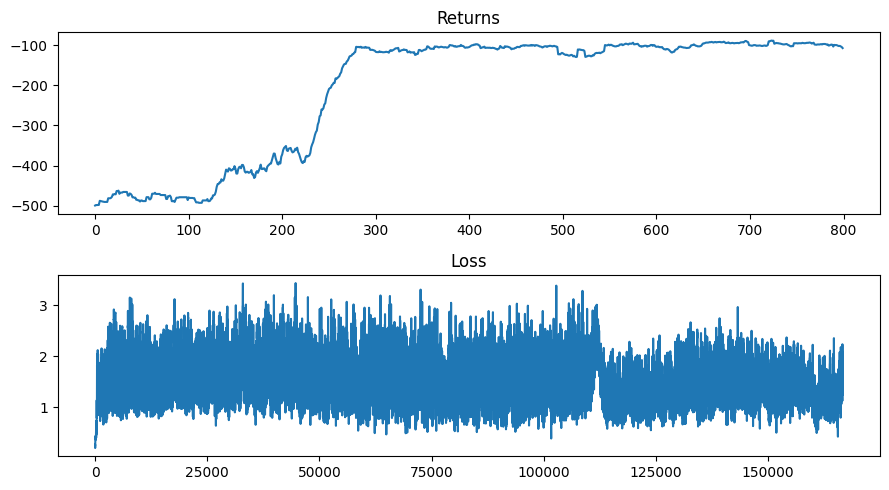

In [5]:

import os, random
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import copy

# ------------------- config  -------------------
ENV_ID                 = "Acrobot-v1"
SEED                   = 42
GAMMA                  = 0.995
LR                     = 1e-3
BATCH_SIZE             = 64
BUFFER_SIZE            = 100_000
START_TRAINING_AFTER   = 1000       # warmup steps
TARGET_UPDATE_FREQ     = 10       # steps (hard update)
MAX_EPISODES           = 800

GRAD_CLIP_NORM         = 10.0
PRINT_EVERY_EPISODES   = 10

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

state_dims = int(np.prod(env.observation_space.shape))  # Acrobot: 6
num_actions = env.action_space.n                        # Acrobot: 3
print(f"[Env] {ENV_ID} | obs_dim={state_dims}, n_actions={num_actions}")

# ------------------- gym environment -> tensor -------------------
class TWrapper(gym.Wrapper):
    def __init__(self, env): super().__init__(env)
    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        return torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0), info
    def step(self, action):
        a = int(action.item()) if isinstance(action, torch.Tensor) else int(action)
        obs, r, term, trunc, info = self.env.step(a)
        done = bool(term or trunc)
        obs_t = torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0)
        r_t   = torch.tensor([[r]], dtype=torch.float32)
        d_t   = torch.tensor([[done]], dtype=torch.bool)
        return obs_t, r_t, d_t, info

env = TWrapper(env)

# ------------------- Q network -------------------
class QNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_sizes=(128, 128)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], action_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ensure 2D [batch, state_dim] and float dtype
        if x.dim() == 1:
            x = x.unsqueeze(0)
        return self.net(x.float())
   

q_net = QNetwork(state_dims, num_actions)
tgt_net = copy.deepcopy(q_net).eval()

# ------------------- simple replay buffer -------------------
class ReplayBuffer:
    def __init__(self, capacity=BUFFER_SIZE):
        self.capacity, self.mem, self.pos = capacity, [], 0
    def push(self, state, action, reward, next_state, done):
        """Add one transition to the buffer (ring-buffer overwrite)."""
        # Detach to avoid holding computation graphs
        transition = (
            state.detach(),
            action.detach() if isinstance(action, torch.Tensor)
                             else torch.tensor([[int(action)]], dtype=torch.long),
            reward.detach(),
            next_state.detach(),
            done.detach(),
        )
        if len(self.mem) < self.capacity:
            self.mem.append(None)
        self.mem[self.pos] = transition
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size=BATCH_SIZE):
        """Uniformly sample a batch of transitions and stack into tensors."""
        batch = random.sample(self.mem, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states      = torch.cat(states, dim=0)
        actions     = torch.cat(actions, dim=0)
        rewards     = torch.cat(rewards, dim=0)
        next_states = torch.cat(next_states, dim=0)
        dones       = torch.cat(dones, dim=0)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.mem)
    
buffer = ReplayBuffer()
optim  = Adam(q_net.parameters(), lr=LR)

# ------------------- greedy / epsilon-greedy -------------------
@torch.no_grad()
def act_epsilon_greedy(state: torch.Tensor, eps: float) -> torch.Tensor:
    if torch.rand(1).item() < eps:
        return torch.randint(num_actions, (1, 1))
    q = q_net(state)
    return torch.argmax(q, dim=-1, keepdim=True)

# ------------------- train loop (Double DQN target) -------------------
def train():
    returns_hist, loss_hist = [], []

    EPS_START, EPS_END, EPS_DECAY = 1.0, 0.05, 100_000
    global_step = 0

    # for ep in range(1, MAX_EPISODES + 1):
    #     state, _ = env.reset()
    #     ep_return = 0.0

    #     while True:
    #         eps = max(EPS_END, EPS_START - (EPS_START - EPS_END) * (global_step / EPS_DECAY))
    #         action = act_epsilon_greedy(state, eps)

    #         next_state, reward, done_t, _ = env.step(action)
    #         buffer.push(state, action, reward, next_state, done_t)

    #         state = next_state
    #         ep_return += float(reward.item())
    #         global_step += 1

    #         # optimize
    #         if len(buffer) >= max(BATCH_SIZE, START_TRAINING_AFTER):
    #             s, a, r, ns, d = buffer.sample(BATCH_SIZE)

    #             # Q(s,a)
    #             q_sa = q_net(s).gather(1, a.long())

    #             # ---------------- DQN target ----------------
    #             with torch.no_grad():
    #                 max_next_q = tgt_net(ns).max(dim=1, keepdim=True)[0]
    #                 target = r + GAMMA * (1.0 - d.float()) * max_next_q

    #             loss = F.smooth_l1_loss(q_sa, target)

    #             optim.zero_grad(set_to_none=True)
    #             loss.backward()
    #             nn.utils.clip_grad_norm_(q_net.parameters(), GRAD_CLIP_NORM)
    #             optim.step()

    #             loss_hist.append(loss.item())

    #         # hard target update (by steps)
    #         if global_step % TARGET_UPDATE_FREQ == 0:
    #             tgt_net.load_state_dict(q_net.state_dict())

    #         if bool(done_t.item()):
    #             break

    #     returns_hist.append(ep_return)

    #     if ep % PRINT_EVERY_EPISODES == 0:
    #         print(f"[DQN]   Ep {ep:4d} | Return {ep_return:8.2f} | eps={eps:.3f} | steps={global_step}")

    for ep in range(1, MAX_EPISODES + 1):
        state, _ = env.reset()
        ep_return = 0.0

        while True:
            eps = max(EPS_END, EPS_START - (EPS_START - EPS_END) * (global_step / EPS_DECAY))
            action = act_epsilon_greedy(state, eps)

            next_state, reward, done_t, _ = env.step(action)
            buffer.push(state, action, reward, next_state, done_t)

            state = next_state
            ep_return += float(reward.item())
            global_step += 1

            # optimize
            if len(buffer) >= max(BATCH_SIZE, START_TRAINING_AFTER):
                s, a, r, ns, d = buffer.sample(BATCH_SIZE)

                # Q(s,a)
                q_sa = q_net(s).gather(1, a.long())

                # ---------------- Double DQN target ----------------
                with torch.no_grad():
                    # online network selects argmax action
                    next_actions = q_net(ns).argmax(dim=1, keepdim=True)
                    # target network evaluates that action
                    next_q = tgt_net(ns).gather(1, next_actions)
                    target = r + GAMMA * (1.0 - d.float()) * next_q

                loss = F.smooth_l1_loss(q_sa, target)

                optim.zero_grad(set_to_none=True)
                loss.backward()
                nn.utils.clip_grad_norm_(q_net.parameters(), GRAD_CLIP_NORM)
                optim.step()

                loss_hist.append(loss.item())

            # hard target update (by steps)
            if global_step % TARGET_UPDATE_FREQ == 0:
                tgt_net.load_state_dict(q_net.state_dict())

            if bool(done_t.item()):
                break

        returns_hist.append(ep_return)

        if ep % PRINT_EVERY_EPISODES == 0:
            print(f"[DDQN]  Ep {ep:4d} | Return {ep_return:8.2f} | eps={eps:.3f} | steps={global_step}")


    plot_stats({"Returns": returns_hist, "Loss": loss_hist})

# ------------------- plotting -------------------
def _smooth(x, w=21):
    if len(x) < w: return x
    k = w // 2
    return [np.mean(x[max(0, i-k):min(len(x), i+k+1)]) for i in range(len(x))]

def plot_stats(stats: dict, win: int = 21):
    fig, axs = plt.subplots(len(stats), 1, figsize=(9, 5), tight_layout=True)
    if len(stats) == 1: axs = [axs]
    for ax, (k, v) in zip(axs, stats.items()):
        ax.plot(_smooth(v, win))
        ax.set_title(k)
    plt.show()
    plt.close()

train()
env.close()


### 1.2 Change classical DQN to double DQN

Use **two networks**:
- **Online** network selects the next action  
  $$
  a^* = \arg\max_{a'} Q_{\text{online}}(s', a').
  $$
- **Target** network evaluates that action  
  $$
  y_{\text{DDQN}} = r + \gamma\, Q_{\text{target}}(s', a^*).
  $$
  
This decoupling reduces overestimation while keeping the update otherwise unchanged.

In the code you will only need to change several lines. 

**TODO:** Comment the vanilla DQN and write Double DQN at the same place.

## Problem 2: Policy Gradient

<!-- #### reparameterization trick:

Let $x$ be a random variable whose distribution depends on $\theta$. Write this as $x\sim p_\theta(x)$. For any measurable $V:\mathcal X\to\mathbb R$,
$$
\mathbb{E}\big[V(f(\theta))\big] \;=\; \mathbb{E}_{x\sim p_\theta}[V(x)],
$$
where $p_\theta$ is the distribution of $x$ induced by $\theta$. This help us move complex functions from expectation to distribution.

Take the gradient gives us

$$
\nabla \mathbb{E}_{x\sim p_\theta}[V(x)] = \int \nabla p_\theta(x) V(x) dx = \int \nabla \ln(p_\theta(x)) V(x) p_\theta(x)dx = \mathbb{E}_{x\sim p_\theta}[V(x) \nabla \ln(p_\theta(x))]
$$

So now we only need to take derivative of the distribution.

### RL as an Expectation over Trajectories
The cost over a distribution of $s_0$ gives the definition of reward function $J$:

$$
\mathbb{E}_{s_0\sim\rho}[V^{\pi_\theta}(s_0)]
$$

But use the trick above we can rewrite that using trajectory. A trajectory is
$$
\tau=(s_0,a_0,s_1,a_1,\ldots,s_T),
$$
generated by initial state distribution $\rho$, policy $\pi_\theta(a\mid s)$, and dynamics $P(s'\mid s,a)$. The trajectory distribution is
$$
p_\theta(\tau)=\rho(s_0)\prod_{t=0}^{T-1}\pi_\theta(a_t\mid s_t)\,P(s_{t+1}\mid s_t,a_t).
$$
Define the discounted return
$$
G(\tau)=\sum_{t=0}^{T-1}\gamma^t\,r(s_t,a_t).
$$
Then the performance objective is
$$
\,J(\theta)=\mathbb{E}_{\tau\sim p_\theta}[G(\tau)]\,
$$

This helps move the $\theta$ to distribution.
 -->

### Recall: Policy-Gradient Theorem

$$
\begin{aligned}
\nabla_\theta J(\theta)
&= \nabla_\theta \mathbb{E}_{\tau\sim p_\theta}[G(\tau)]
= \mathbb{E}_{\tau\sim p_\theta}\!\left[G(\tau)\,\nabla_\theta\log p_\theta(\tau)\right] \\
&= \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t\mid s_t)\,G(\tau)\right] \\
\end{aligned} \tag{F1}
$$

This is the first gradient formulation we arrive at (here $G(\tau) = R(\tau)$ and $R(\tau)$ is the notation used in Lecture notes). A naive collary is the using causality to change that to return-to-go:

$$
\begin{aligned}
\nabla_\theta J(\theta)
&= \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,G_t(\tau)\right]
\end{aligned} \tag{F2} 
$$

where $G_t=\sum_{k=t}^{T-1}\gamma^{k-t}r(s_k,a_k)$ and $d^{\pi_\theta}$ is the discounted state-visitation distribution. Next, we observe that 

$$
\mathbb{E}_{a_t\sim\pi_\theta}\!\left[\nabla_\theta\log\pi_\theta(a_t\mid s_t)\,b(s_t)\right]=0,
$$

<!-- This is because condition on $s_t$, $b(s_t)$ is a constant inside expectation, and $\mathbb{E}_{a_t\sim\pi_\theta}\!\left[\nabla_\theta\log\pi_\theta(a_t\mid s_t)\right]=0$.  -->

Plug in the "baseline" $b(s_t)$ into the policy gradient gives us

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,(G_t(\tau)- b(s_t))\right] \tag{F3}
$$

In practice most of the time people use the learned value function for the baseline.

### Policy gradient theorem (extended)

Next we talk about another 3 chosen of policy gradient:

From (F2) gradient we can easily see that $Q(s_t,a_t) = \mathbb{E}[G_t(\tau)]$, so plug in F2 gives us
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,Q(s_t,a_t)\right] \tag{F4}
$$

And followed by previous explanation of baseline, we can define $A(s_t,a_t) = Q(s_t,a_t) - V(s_t)$, thus we arrive the *advantage function* gradient.
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,A(s_t,a_t)\right] \tag{F5}
$$

The last formulation is by observing that
$$
\mathbb{E}[Q(s_t,a_t)] = \mathbb{E}[r(s_t,a_t) + \gamma V(s_{t+1})]
$$

apply baseline to it gives us
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,(r(s_t,a_t) + \gamma V(s_{t+1}) - V(s_t))\right] \tag{F6}
$$

### 2.1 Convergence of Different Policy-Gradient Estimators

We study a random walk on a ring. Let $\mathcal{S}=\mathbb{Z}_N$ and $\mathcal{A}=\{L,R\}$. The dynamics and rewards are
$$
s_{t+1}\equiv s_t+\begin{cases}
+1 & \text{if }a_t = R, \\
-1 & \text{if }a_t = L,
\end{cases}\ (\mathrm{mod}\,N),\qquad
r_t \equiv \begin{cases}
r_\text{terminal} & \text{if done} \\
r_\text{step} & \text{otherwise}
\end{cases},\quad \gamma\in(0,1).
$$

Because this is tabular, Bellman consistency (Eq. 1.21) yields a linear system $AV=b$ (as in PSET1, Problem 4). Solving gives the exact values $V$, and $Q$ follows by one-step lookahead.

**TODO:**
1. Implement a minimal MLP policy ($x=s/N\to\pi_\theta(\cdot\mid s)$) with a Softmax output.  
2. Implement six MC gradient estimators: REINFORCE, return-to-go, baseline with $V$, using $Q$, advantage $Q{-}V$, and TD-residual.  
3. Plot per-parameter sample std and the running-mean error $\|\bar g_k-\nabla_\theta J\|_2$ vs. episodes, plus $|\bar J_k-J_{\text{true}}|$.
   $$\bar g_k = \frac{1}{k} \sum_i^k g_i, \quad \bar J_k = \frac{1}{k} \sum_i^k J_i$$
   
4. Comment on what you see, and explain it intuitively.

Note:

Here we provide the function `build_system`, `get_V_and_J` and `get_Q` for calculate the true value / action value. `finite_difference_grad` for approximate the true objective / gradient by finite difference. And also `logp_single` and `score_matrix_batch` for calculate $\nabla J_\theta$ in a batched manner (You can also use for-loop, but that takes quite long run time). But feel free to use your own code.



Per-parameter standard deviation (over episodes):
g1: REINFORCE (full): [ 4.4271336 10.341715   8.245393  17.721275  40.174652  25.595325
 40.174652  25.595325  59.186672  59.186676 ]
g2: Return-to-go: [ 10.076121  23.05821   19.51999   42.016182  95.11873   59.427074
  95.11873   59.427086 140.12701  140.12701 ]
g3: Baseline V: [  9.051165  20.777412  17.450428  37.508163  85.0282    53.602123
  85.028206  53.60213  125.26582  125.26583 ]
g4: Using Q: [ 3.8595765  9.113507   7.14338   15.319232  34.804317  22.20113
 34.804317  22.201132  51.275497  51.275497 ]
g5: Advantage Q-V: [ 2.6975744  6.3653846  5.1521416 10.999561  25.100525  15.947493
 25.100525  15.947493  36.98105   36.981045 ]
g6: TD residual: [ 6.9406075 16.32526   13.081786  27.727795  63.701904  42.617622
 63.70191   42.61763   93.8685    93.86851  ]


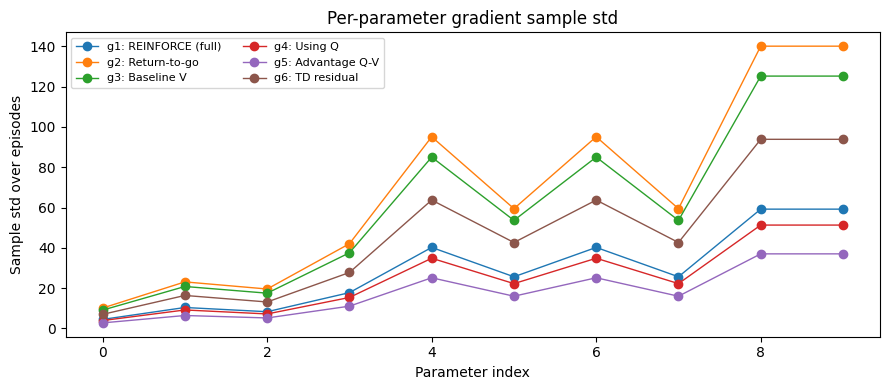

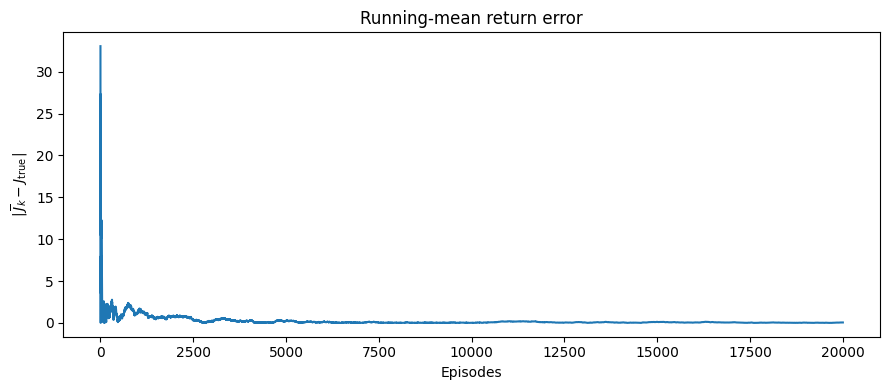

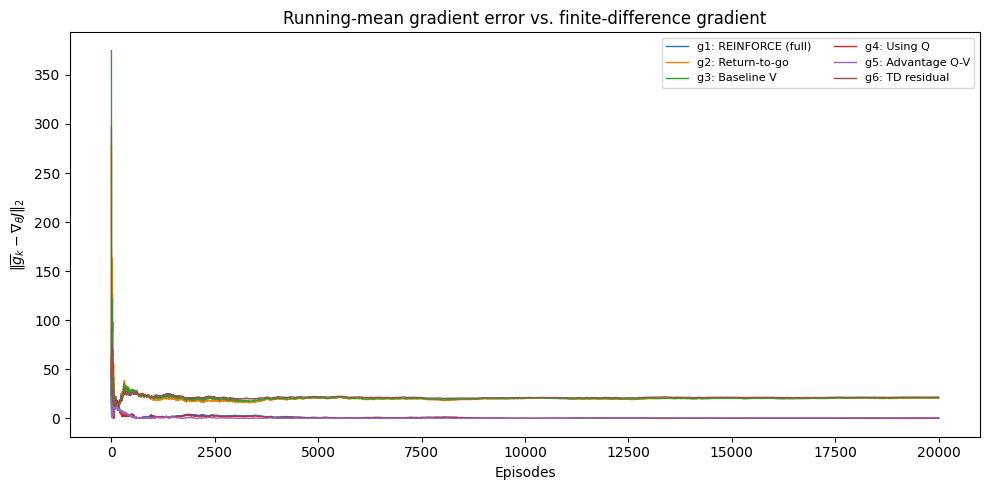

In [ ]:
import math, random
from typing import Tuple, List
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import matplotlib.pyplot as plt
from torch.func import functional_call, vmap, jacrev


# ----------------- utilities -----------------
def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# ----------------- policy network (last layer Softmax) -----------------
class PolicyNet(nn.Module):
    #########################################
    #TODO 2.1: Implement the policy network
    #########################################
    def __init__(self, hidden: int = 16):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden)
        self.fc2 = nn.Linear(hidden, 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x can be shape (B,) or (B,1); normalize to (B,1)
        if x.dim() == 1:
            x = x.unsqueeze(-1)
        h = torch.tanh(self.fc1(x))
        logits = self.fc2(h)
        return F.softmax(logits, dim=-1)
    

# ----------------- DP: exact J(θ) using policy p_s -----------------
def build_system(model: PolicyNet, N: int, gamma: float,
                 running_reward: float, terminal_reward: float):
    """
    In tabular case, we could build A,b directly from the bellman's equations (eq 1.21 in lecture note).
    Build linear system A V = b for states s=1..N-1.
    Transition probabilities p_s come from the torch policy (Right prob).
    """
    model.eval()
    with torch.no_grad():
        s_idx = torch.arange(1, N, dtype=torch.float32)
        x = s_idx / float(N)                  # (N-1,)
        pi = model(x)                         # (N-1, 2)
        p = pi[:, 1].cpu().numpy()            # P(right | s)
        q = (1.0 - p)                         # P(left  | s)

    A = np.zeros((N-1, N-1), dtype=np.float64)
    b = np.zeros(N-1, dtype=np.float64)

    if N - 1 == 1:
        A[0, 0] = 1.0
        b[0] = terminal_reward
        return A, b

    # s = 1 (index 0)
    A[0, 0] = 1.0
    A[0, 1] = -gamma * p[0]
    b[0] = q[0] * terminal_reward + p[0] * running_reward

    # s = 2..N-2 (indices 1..N-3)
    for s in range(2, N-1):
        i = s - 1
        A[i, i]   = 1.0
        A[i, i-1] = -gamma * q[i]
        A[i, i+1] = -gamma * p[i]
        b[i]      = running_reward

    # s = N-1 (index N-2)
    i = N - 2
    A[i, i]   = 1.0
    A[i, i-1] = -gamma * q[i]
    b[i]      = p[i] * terminal_reward + q[i] * running_reward
    return A, b

def get_V_and_J(model: PolicyNet, N: int, gamma: float,
                running_reward: float, terminal_reward: float):
    """Solve A V = b; return V(s) for s=1..N-1 and uniform-start J."""
    A, b = build_system(model, N, gamma, running_reward, terminal_reward)
    V = np.linalg.solve(A, b)
    return V, float(V.mean())

def get_Q(model: PolicyNet, N: int, gamma: float,
          running_reward: float, terminal_reward: float):
    """
    Q(s,a) via one-step lookahead using V from DP.
    Returns Q for s=1..N-1 (shape (N-1, 2)).
    """
    V, _ = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
    V_full = np.zeros(N + 1)
    V_full[1:N] = V
    s = np.arange(1, N, dtype=np.int64)
    sL, sR = s - 1, s + 1
    rL = np.where(sL == 0, terminal_reward, running_reward)
    rR = np.where(sR == N, terminal_reward, running_reward)
    Q = np.empty((N-1, 2), dtype=np.float64)
    Q[:, 0] = rL + gamma * V_full[sL]
    Q[:, 1] = rR + gamma * V_full[sR]
    return Q

# ----------------- Finite-difference gradient on θ (torch) -----------------
def finite_difference_grad(model: PolicyNet, N: int, gamma: float,
                           running_reward: float, terminal_reward: float,
                           eps: float = 1e-4, relative: bool = False,
                           scheme: str = 'central'):
    """
    Finite-difference ∇θ J where θ is the concatenated torch parameter vector.
    Supports central or forward difference. Optional relative step size.
    """
    theta0 = parameters_to_vector(model.parameters()).detach().clone()
    _, J0 = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
    grad = torch.zeros_like(theta0)

    for i in range(theta0.numel()):
        base = float(abs(theta0[i])) if relative else 1.0
        h = eps * max(1.0, base)

        if scheme.lower() == 'central':
            th_p = theta0.clone(); th_p[i] += h
            th_m = theta0.clone(); th_m[i] -= h
            vector_to_parameters(th_p, model.parameters())
            Jp = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            vector_to_parameters(th_m, model.parameters())
            Jm = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            grad[i] = (Jp - Jm) / (2.0 * h)
        elif scheme.lower() == 'forward':
            th_p = theta0.clone(); th_p[i] += h
            vector_to_parameters(th_p, model.parameters())
            Jp = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            grad[i] = (Jp - J0) / h
        else:
            raise ValueError("scheme must be 'central' or 'forward'")

    # restore original params
    vector_to_parameters(theta0, model.parameters())
    return J0, grad.detach()

# ----------------- MC gradient estimators (REINFORCE family) -----------------
def mc_grad_estimators(model: PolicyNet, N: int, s0_batch: torch.Tensor, gamma: float,
                       step_cost: float, terminal_reward: float,
                       V: torch.Tensor = None, Q: torch.Tensor = None):
    """
    We compute per-sample score vectors using autograd by calling backward()
    on log π(a_t|s_t) to obtain ∇θ log π(a_t|s_t).

    Returns (all numpy arrays):
      g1..g6: (B, P) per-episode gradient samples; J: (B,)
        g1: full-return REINFORCE
        g2: return-to-go REINFORCE (via cumulative scores H)
        g3: baseline with V(s_t)
        g4: use Q(s_t, a_t)
        g5: use Advantage A = Q − V
        g6: use TD residual δ_t = r_t + γ V(s_{t+1}) − V(s_t)
    """
    device = next(model.parameters()).device
    model.eval()
    
    names, base_params = zip(*list(model.named_parameters()))
    # Detach so these are leaf tensors, then turn grad on (required by jacrev)
    params = tuple(p.detach().requires_grad_(True) for p in base_params)
    P = sum(p.numel() for p in params)

    B = int(s0_batch.numel())
    s    = s0_batch.to(device).clone()
    done = (s == 0) | (s == N)

    H  = torch.zeros(B, P, device=device)  # cumulative score per-episode
    g1 = torch.zeros(B, P, device=device)
    g2 = torch.zeros(B, P, device=device)
    g3 = torch.zeros(B, P, device=device)
    g4 = torch.zeros(B, P, device=device)
    g5 = torch.zeros(B, P, device=device)
    g6 = torch.zeros(B, P, device=device)
    J  = torch.zeros(B,   device=device)
    gpw= torch.ones (B,   device=device)  # γ^t

    if V is not None:
        V = V.to(device)     # shape N+1, suggest V[0]=V[N]=0
    if Q is not None:
        Q = Q.to(device)     # shape (N+1,2), with Q(0,.)=Q(N,.)=0 if you padded
    
    def logp_single(param_tensors, s_scalar: torch.Tensor, a_scalar: torch.Tensor):
        # Build a param dict for functional_call
        pmap = {n: t for n, t in zip(names, param_tensors)}
        x = (s_scalar.float() / float(N)).view(1, 1)
        probs = functional_call(model, pmap, (x,))    # (1,2)
        # Differentiable action selection via gather (avoid data-dependent indexing pitfalls)
        logp = probs.log().gather(1, a_scalar.long().view(1, 1)).squeeze()  # scalar
        return logp

    # Note: you may found this function useful, this calculate ∇θ log π(a_i|s_i) in a batch manner
    def score_matrix_batch(active_s: torch.Tensor, active_a: torch.Tensor) -> torch.Tensor:
        """
        Returns (B_act, P) where each row is ∇θ log π(a_i|s_i),
        computed efficiently via vmap(jacrev) over (s,a).
        """
        # jac is a pytree of tensors matching param shapes, each with leading dim B_act
        jac = vmap(jacrev(logp_single), in_dims=(None, 0, 0))(params, active_s, active_a)
        # Flatten each param’s jacobian and concatenate along feature dim
        parts = [g.reshape(g.shape[0], -1) for g in jac]
        return torch.cat(parts, dim=1)  # (B_act, P)


    while not torch.all(done):
        idx = (~done).nonzero(as_tuple=False).squeeze(1)
        if idx.numel() == 0:
            break

        # Sample actions for all active states in one forward pass
        x = (s[idx].float() / float(N)).unsqueeze(1)
        with torch.no_grad():
            probs = model(x)                            # (B_act, 2)
            a = torch.multinomial(probs, 1).squeeze(1) # (B_act,)

        # ∇θ log π(a|s): (B_act, P) using backward()
        score_mat = score_matrix_batch(s[idx], a)

        # Next state, termination, and rewards
        s_next   = s[idx] + torch.where(a == 1, 1, -1)
        term_any = (s_next == 0) | (s_next == N)
        r_t = torch.where(
            term_any,
            torch.tensor(terminal_reward, device=device),
            torch.tensor(step_cost, device=device)
        ).float()
        
        #########################################
        #TODO 2.1: Implement the six policy gradient estimators
        #########################################
        # -- Accumulate running objects we need --
        # Sum of (undiscounted) scores for REINFORCE (full return)
        if 'Sfull' not in locals():
            Sfull = torch.zeros(B, P, device=device)
        Sfull[idx] += score_mat

        H[idx] = gamma * H[idx] + score_mat  # (B_act, P)

        g2[idx] += r_t.view(-1, 1) * H[idx]

        w = gpw[idx].view(-1, 1)

        if V is not None:
            V_st = V[s[idx]]  # (B_act,)
            g3[idx] += r_t.view(-1,1) * H[idx] - w * V_st.view(-1,1) * score_mat

        if Q is not None:
            Qa = Q[s[idx], a]  # (B_act,)
            g4[idx] += w * Qa.view(-1,1) * score_mat

        if (Q is not None) and (V is not None):
            adv = Qa - V_st  # (B_act,)
            g5[idx] += w * (Qa - V_st).view(-1,1) * score_mat

        if V is not None:
            V_snext = V[s_next]  # (B_act,)
            delta = r_t + gamma * V_snext - V_st
            g6[idx] += delta.view(-1, 1) * H[idx]

        J[idx]   += gpw[idx] * r_t
        gpw[idx] *= gamma

        s[idx] = s_next
        done[idx] = term_any | done[idx]

        if term_any.any():
            term_idx = idx[term_any]
            g1[term_idx] += J[term_idx].view(-1, 1) * Sfull[term_idx]
        
    return (g1.detach().cpu().numpy(),
            g2.detach().cpu().numpy(),
            (g3.detach().cpu().numpy() if V is not None else np.zeros_like(g2.detach().cpu().numpy())),
            (g4.detach().cpu().numpy() if Q is not None else np.zeros_like(g2.detach().cpu().numpy())),
            (g5.detach().cpu().numpy() if (V is not None and Q is not None) else np.zeros_like(g2.detach().cpu().numpy())),
            g6.detach().cpu().numpy() if V is not None else np.zeros_like(g2.detach().cpu().numpy()),
            J.detach().cpu().numpy())

# ----------------- main -----------------
set_seed(0)
device = torch.device("cpu")

# Environment
N = 10
gamma = 0.9
running_reward = -1.0
terminal_reward = 100.0

# Policy
model = PolicyNet(hidden=2).to(device)

# Exact J and FD gradient
J_true, grad_fd = finite_difference_grad(
    model, N, gamma, running_reward, terminal_reward,
    eps=1e-4, relative=True, scheme='central'
)

# Baselines from DP value V(s) and Q(s,a)
V_np, _ = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
V = torch.tensor(np.concatenate(([0.0], V_np, [0.0])), dtype=torch.float32, device=device)  # V(0)=V(N)=0

Q_np = get_Q(model, N, gamma, running_reward, terminal_reward).astype(np.float32)
Q_t  = torch.tensor(Q_np, dtype=torch.float32, device=device)
zero_row = torch.zeros(1, 2, dtype=torch.float32, device=device)
Q = torch.cat([zero_row, Q_t, zero_row], dim=0)  # Q(0,.)=Q(N,.)=0

# Monte Carlo (batched episodes)
episodes = 20000  # adjust as needed
s0_batch = torch.randint(1, N, (episodes,), dtype=torch.int64, device=device)
g1, g2, g3, g4, g5, g6, J = mc_grad_estimators(
    model, N, s0_batch, gamma,
    step_cost=running_reward,
    terminal_reward=terminal_reward,
    V=V, Q=Q
)

#########################################
#TODO 2.1: Plot your result here
# 1. Print out the standard deviation of each gradient estimator
# 2. Plot the running error of the estimated J vs the true J, you may found np.cumsum(:, axis=0) / np.arange(1, len(J) + 1) useful
# 3. Plot the running error of each gradient estimator vs the FD gradient
#########################################

# 1) Per-parameter sample std (over episodes)
labels = ["g1: REINFORCE (full)", "g2: Return-to-go", "g3: Baseline V",
          "g4: Using Q", "g5: Advantage Q-V", "g6: TD residual"]
Gs = [g1, g2, g3, g4, g5, g6]

stds = [np.std(G, axis=0) for G in Gs]  # list of (P,) arrays
P = stds[0].size

print("\nPer-parameter standard deviation (over episodes):")
for name, sv in zip(labels, stds):
    print(f"{name}: {sv}")

# Plot per-parameter std (all estimators on one plot)
plt.figure(figsize=(9, 4))
x = np.arange(P)
for name, sv in zip(labels, stds):
    plt.plot(x, sv, marker='o', linewidth=1, label=name)
plt.xlabel("Parameter index")
plt.ylabel("Sample std over episodes")
plt.title("Per-parameter gradient sample std")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# 2) Running error of estimated J vs true J
J_true_scalar = J_true  # from finite_difference_grad call above
J_running_mean = np.cumsum(J) / np.arange(1, len(J) + 1)
J_err = np.abs(J_running_mean - J_true_scalar)

plt.figure(figsize=(9, 4))
plt.plot(J_err)
plt.xlabel("Episodes")
plt.ylabel(r"$|\,\overline{J}_k - J_{\mathrm{true}}\,|$")
plt.title("Running-mean return error")
plt.tight_layout()
plt.show()

# 3) Running error of each gradient estimator vs FD gradient
grad_fd_np = grad_fd.detach().cpu().numpy()

def running_mean_rows(X):
    # X: (B, P) -> running mean (B, P)
    csum = np.cumsum(X, axis=0)
    ks = np.arange(1, X.shape[0] + 1)[:, None]
    return csum / ks

plt.figure(figsize=(10, 5))
for name, G in zip(labels, Gs):
    Gbar = running_mean_rows(G)           # (B, P)
    err  = np.linalg.norm(Gbar - grad_fd_np[None, :], axis=1)  # (B,)
    plt.plot(err, label=name, linewidth=1)

plt.xlabel("Episodes")
plt.ylabel(r"$\|\overline{g}_k - \nabla_\theta J\|_2$")
plt.title("Running-mean gradient error vs. finite-difference gradient")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()


### 2.2 REINFORCE algorithm

**Algorithm Recap — REINFORCE (Monte-Carlo Policy Gradient)**

1. **Policy network**  
   Stochastic policy $\pi_\theta(a\mid s)$ 

2. **Trajectory sampling**  
   Roll out episodes with $\pi_\theta$: $(s_1,a_1,r_1,\dots,s_T,a_T,r_T)$.

3. **Returns / advantages**
   - Monte-Carlo return:
     $$
     G_t=\sum_{t'=t}^{T}\gamma^{\,t'-t} r_{t'}.
     $$
   - Advantage: $A_t = G_t - b(s_t)$.

4. **Policy-gradient update**
   - Estimator:
     $$
     \hat g(\theta)=\frac{1}{N}\sum_{i=1}^{N}\sum_{t=1}^{T_i}
       \nabla_\theta \log \pi_\theta(a_t^{(i)}\mid s_t^{(i)})\, \gamma^t A_t^{(i)}.
     $$
   - Gradient ascent: $\theta \leftarrow \theta + \alpha\,\hat g(\theta)$.

5. **Learned value baseline (optional)**
   - Regress $V_\psi(s)$ to returns:
     $$
     \min_\psi \frac{1}{N}\sum_{i,t}\big(V_\psi(s_t^{(i)})-G_t^{(i)}\big)^2,
     \qquad A_t\!=\!G_t\!-\!V_\psi(s_t).
     $$

6. **Mini-batch training**
   - Collect $N$ episodes (or $M$ steps), compute $G_t/A_t$; optimize
     $$
     \mathcal{L}_{\text{PG}}(\theta)=
     -\frac{1}{N}\sum_{i,t}\log\pi_\theta(a_t^{(i)}\mid s_t^{(i)})\,A_t^{(i)}.
     $$

**TODO:**
- implement policy net and value net
- implement the main algorithm


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym

# ------------------- hyperparameters -------------------
ENV_ID = "Acrobot-v1"
SEED = 0
HIDDEN = 128
GAMMA = 0.995

LR_POLICY = 3e-4
LR_VALUE  = 1e-3
MAX_EPOCHS = 400
BATCH_SIZE = 16
MAX_EP_LEN = 1000
VALUE_UPDATES = 10

GRAD_CLIP = 10.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

obs_dim = env.observation_space.shape[0]   # 6 for Acrobot
act_dim = env.action_space.n               # 3 for Acrobot

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

# ------------------- tensor wrapper (given as a reference) -------------------
class TWrapper(gym.Wrapper):
    def __init__(self, env): super().__init__(env)
    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        return torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0), info
    def step(self, action):
        a = int(action.item()) if isinstance(action, torch.Tensor) else int(action)
        obs, r, term, trunc, info = self.env.step(a)
        done = bool(term or trunc)
        obs_t = torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0)
        r_t   = torch.tensor([[r]], dtype=torch.float32)
        d_t   = torch.tensor([[done]], dtype=torch.bool)
        return obs_t, r_t, d_t, info
    
env = TWrapper(env)

# ------------------- discrete policy net (given as a reference) -------------------
class PolicyNet(nn.Module):
    #########################################
    #TODO 2.2: Implement policy network
    #########################################

    def __init__(self, obs_dim: int, hidden: int, act_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, act_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
    
# ------------------- value baseline (given as a reference) -------------------
class ValueNet(nn.Module):
    #########################################
    #TODO 2.2: Implement value network
    #########################################

    def __init__(self, obs_dim: int, hidden: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
    
    
policy = PolicyNet(obs_dim=obs_dim, hidden=HIDDEN, act_dim=act_dim).to(DEVICE)
vnet   = ValueNet(obs_dim=obs_dim, hidden=HIDDEN).to(DEVICE)

# ------------------- utils -------------------
def mc_returns_single_traj(R: torch.Tensor, gamma: float) -> torch.Tensor:
    """R: [T] -> G: [T], reverse within a single trajectory."""
    G = torch.zeros_like(R)
    running = 0.0
    for t in range(R.numel() - 1, -1, -1):
        running = R[t] + gamma * running
        G[t] = running
    return G

# ------------------- training -------------------
def train():
    #########################################
    #TODO 2.2: Implement vanilla REINFORCE algorithm
    #########################################

    policy.train(); vnet.train()
    opt_pi = torch.optim.Adam(policy.parameters(), lr=LR_POLICY)
    opt_v  = torch.optim.Adam(vnet.parameters(),   lr=LR_VALUE)

    returns_history = []

    for epoch in range(MAX_EPOCHS):
        batch_obs   = []
        batch_G     = []
        batch_logp  = []
        batch_w     = []         # γ^t weights
        ep_returns  = []

        # ----- collect BATCH_SIZE episodes -----
        for _ in range(BATCH_SIZE):
            obs, _ = env.reset(seed=None)
            obs = obs.to(DEVICE)

            traj_obs, traj_logp, traj_rew, traj_w = [], [], [], []
            gamma_t = 1.0

            for t in range(MAX_EP_LEN):
                logits = policy(obs.to(DEVICE))
                dist   = Categorical(logits=logits)
                act    = dist.sample()
                logp   = dist.log_prob(act)  # shape (1,)

                next_obs, r, done, _ = env.step(act)
                traj_obs.append(obs.squeeze(0))
                traj_logp.append(logp.squeeze(0))
                traj_rew.append(r.squeeze())           # scalar tensor
                traj_w.append(torch.tensor(gamma_t, device=DEVICE))

                obs = next_obs.to(DEVICE)
                gamma_t *= GAMMA
                if done.item():
                    break

            # Returns for this trajectory
            R = torch.stack(traj_rew).to(DEVICE)                 # [T]
            G = mc_returns_single_traj(R, GAMMA)                 # [T]
            O = torch.stack(traj_obs).to(DEVICE)                 # [T, obs_dim]
            LP= torch.stack(traj_logp).to(DEVICE)                # [T]
            W = torch.stack(traj_w).to(DEVICE)                   # [T]

            # Value baseline (for advantages); detach so policy loss doesn’t backprop through vnet
            with torch.no_grad():
                V = vnet(O).squeeze(-1)                          # [T]
            A = (G - V).detach()

            batch_obs.append(O)
            batch_G.append(G)
            batch_logp.append(LP * W)    # include γ^t here per estimator in recap
            batch_w.append(A)

            ep_returns.append(G[0].item())

        returns_history.append(float(np.mean(ep_returns)))

        # ----- policy update -----
        logp_w = torch.cat(batch_logp, dim=0)  # [sum T_i]
        adv    = torch.cat(batch_w,   dim=0)   # [sum T_i]
        policy_loss = -(logp_w * adv).mean()

        opt_pi.zero_grad(set_to_none=True)
        policy_loss.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), GRAD_CLIP)
        opt_pi.step()

        # ----- value-function updates -----
        O_all = torch.cat(batch_obs, dim=0)        # [N, obs_dim]
        G_all = torch.cat(batch_G,   dim=0).detach()  # [N]

        for _ in range(VALUE_UPDATES):
            v_pred = vnet(O_all).squeeze(-1)
            v_loss = F.mse_loss(v_pred, G_all)
            opt_v.zero_grad(set_to_none=True)
            v_loss.backward()
            nn.utils.clip_grad_norm_(vnet.parameters(), GRAD_CLIP)
            opt_v.step()

        if (epoch + 1) % 10 == 0:
            print(f"epoch {epoch+1:4d} | "
                  f"return {np.mean(ep_returns):8.2f} | "
                  f"pi_loss {policy_loss.item():.4f}")

    
    print("Training finished.")
    return policy, vnet, returns_history

policy, vnet, returns_history = train()

def eval(policy, episodes=10, greedy=True, device=DEVICE, max_len=MAX_EP_LEN):
    env = gym.make("Acrobot-v1")
    policy.eval()
    succ, max_hs = [], []
    with torch.no_grad():
        for _ in range(episodes):
            o, _ = env.reset()
            ok, m = False, -1e9
            for _ in range(max_len):
                s = torch.as_tensor(o, dtype=torch.float32, device=device).unsqueeze(0)
                logits = policy(s)
                a = int(logits.argmax(-1)) if greedy else int(Categorical(logits=logits).sample())
                o, r, term, trunc, _ = env.step(a)
                c1, s1, c2, s2 = o[:4]; m = max(m, float(-c1 - (c1*c2 - s1*s2)))  # tip height
                if term or trunc: ok = bool(term); break
            succ.append(ok); max_hs.append(m)
    print(f"success={np.mean(succ):.1%}, mean_max_tip={np.mean(max_hs):.3f}")
    
eval(policy, episodes=100, greedy=True)

epoch   10 | return  -183.00 | pi_loss -54.3749
epoch   20 | return  -179.00 | pi_loss -48.3136
epoch   30 | return  -179.95 | pi_loss -42.2486
epoch   40 | return  -151.34 | pi_loss -29.0442
epoch   50 | return  -137.18 | pi_loss -19.2301
epoch   60 | return  -119.26 | pi_loss -8.5255
epoch   70 | return  -102.32 | pi_loss -2.5212
epoch   80 | return   -87.56 | pi_loss 2.8792
epoch   90 | return   -80.57 | pi_loss 4.5591
epoch  100 | return   -81.73 | pi_loss 1.8054
epoch  110 | return   -73.77 | pi_loss 1.2362
epoch  120 | return   -75.31 | pi_loss 1.4265
epoch  130 | return   -74.67 | pi_loss 0.3275
epoch  140 | return   -75.86 | pi_loss -0.9451
epoch  150 | return   -69.62 | pi_loss -0.5142
epoch  160 | return   -72.80 | pi_loss -0.1275
epoch  170 | return   -71.28 | pi_loss -1.6432
epoch  180 | return   -72.10 | pi_loss -0.3415
epoch  190 | return   -66.59 | pi_loss 0.4013
epoch  200 | return   -68.07 | pi_loss 1.6381
epoch  210 | return   -69.50 | pi_loss -0.7494
epoch  220 | ret

## Problem 3: Actor-critic

REINFORCE with learned value function often have high variance (recall what we find in PSET2 2.1). Actor-critic method replace the advantage $A_t = G_t - b(s_t)$ with temporal-difference error $r_t + \gamma V(s_{t+1}) - V(s_t)$

**Algorithm recap**

1. **Networks**
   - **Actor**: stochastic policy $ \pi_\theta(a\mid s) $.
   - **Critic**: value $ V_\psi(s) $
  
2. **Data collection**
   
   Roll out for $n$ steps (or full episodes) with $\pi_\theta$; store $(s_t,a_t,r_t,s_{t+1},\text{done}_t)$.

3. **TD advantage (one-step)**
   $$
   y_t = r_t + \gamma \,V_{\psi}(s_{t+1}),\qquad
   \delta_t = y_t - V_\psi(s_t).
   $$
   Use $\delta_t$ as **advantage** (variance lower than Monte-Carlo $G_t$).

4. **Losses**
   - **Actor**  
     $$
     \mathcal L_{\pi}(\theta)
     = -\,\mathbb E\big[\,\log \pi_\theta(a_t\!\mid s_t)\,\delta_t \big]
     $$
   - **Critic**  
     $$
     \mathcal L_V(\psi) = \tfrac12\,\mathbb E\big[(V_\psi(s_t)-y_t)^2\big].
     $$

Several other features you may consider:
- Multi-step update for value function 
- Normalize the advantage over batch

**TODO:**
- implement policy net and value net
- implement the main algorithm

In [ ]:
# On-policy Actor–Critic for Acrobot-v1
# - Discrete actions, update every K steps (no need to finish episodes)

import math, random
from typing import List, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym

# ------------------- hyperparameters -------------------
ENV_ID = "Acrobot-v1"
SEED = 0
HIDDEN = 128
GAMMA = 0.995

LR_POLICY = 3e-4
LR_VALUE  = 1e-3
MAX_EPOCHS = 500
STEPS_PER_UPDATE = 64           # ← collect this many steps, then update (true on-policy)

CRITIC_UPDATES = 1              # critic updates per actor step
GRAD_CLIP = 10.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

obs_dim = env.observation_space.shape[0]   # 6 for Acrobot
act_dim = env.action_space.n               # 3 for Acrobot

np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)
torch.use_deterministic_algorithms(False)

# ------------------- networks -------------------
class PolicyNet(nn.Module):
    #########################################
    #TODO 3.1: Implement policy network
    #########################################
    def __init__(self, obs_dim: int, hidden: int, act_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, act_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
    

class ValueNet(nn.Module):
    #########################################
    #TODO 3.1: Implement value network
    #########################################
    def __init__(self, obs_dim: int, hidden: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
    

policy = PolicyNet(obs_dim, HIDDEN, act_dim).to(DEVICE)
value  = ValueNet(obs_dim, HIDDEN).to(DEVICE)
opt_pi = torch.optim.Adam(policy.parameters(), lr=LR_POLICY)
opt_v  = torch.optim.Adam(value.parameters(),  lr=LR_VALUE)

# ------------------- helper -------------------
@torch.no_grad()
def to_t(s): return torch.as_tensor(s, dtype=torch.float32, device=DEVICE).unsqueeze(0)

# ------------------- training (A2C / 1-step actor-critic) -------------------
def train():
    returns_history: List[float] = []
    ep_ret, ep_len = 0.0, 0
    obs, _ = env.reset(seed=SEED)
    #########################################
    #TODO 3.1: Implement the main algorithm
    #########################################
    for epoch in range(MAX_EPOCHS):
        # --- collect exactly STEPS_PER_UPDATE on-policy steps ---
        S, A, R, S2, D = [], [], [], [], []

        for _ in range(STEPS_PER_UPDATE):
            s_t = to_t(obs)                        # (1, obs_dim)
            logits = policy(s_t)                   # (1, act_dim)
            dist = Categorical(logits=logits)
            a_t  = dist.sample()                   # (1,)

            o2, r, term, trunc, _ = env.step(int(a_t.item()))
            done = bool(term or trunc)

            # store transition
            S.append(torch.as_tensor(obs, dtype=torch.float32))
            A.append(torch.as_tensor(a_t.item(), dtype=torch.int64))
            R.append(torch.as_tensor(r, dtype=torch.float32))
            S2.append(torch.as_tensor(o2, dtype=torch.float32))
            D.append(torch.as_tensor(done, dtype=torch.bool))

            # episode bookkeeping
            ep_ret += r; ep_len += 1
            obs = o2
            if done:
                returns_history.append(ep_ret)
                obs, _ = env.reset()
                ep_ret, ep_len = 0.0, 0

        # --- stack tensors to DEVICE ---
        S  = torch.stack(S).to(DEVICE)            # [T, obs_dim]
        A  = torch.stack(A).to(DEVICE)            # [T]
        R  = torch.stack(R).to(DEVICE)            # [T]
        S2 = torch.stack(S2).to(DEVICE)           # [T, obs_dim]
        D  = torch.stack(D).to(DEVICE)            # [T]

        # --- critic target and TD-error (one-step) ---
        with torch.no_grad():
            V_next = value(S2).squeeze(-1)                               # [T]
            y = R + GAMMA * (~D).float() * V_next                        # [T]
        V = value(S).squeeze(-1)                                         # [T]
        delta = y - V                                                    # [T]

        # (optional) advantage normalization over the batch
        adv = (delta - delta.mean()) / (delta.std(unbiased=False) + 1e-8)

        # --- actor update: recompute log-probs from current policy ---
        logits_batch = policy(S)                                         # [T, act_dim]
        dist_batch   = Categorical(logits=logits_batch)
        logp_batch   = dist_batch.log_prob(A)                            # [T]
        actor_loss   = -(logp_batch * adv.detach()).mean()

        opt_pi.zero_grad(set_to_none=True)
        actor_loss.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), GRAD_CLIP)
        opt_pi.step()

        # --- critic update(s) ---
        for _ in range(CRITIC_UPDATES):
            V_pred = value(S).squeeze(-1)
            critic_loss = 0.5 * F.mse_loss(V_pred, y.detach())
            opt_v.zero_grad(set_to_none=True)
            critic_loss.backward()
            nn.utils.clip_grad_norm_(value.parameters(), GRAD_CLIP)
            opt_v.step()

        if (epoch + 1) % 10 == 0:
            avg_ret = float(np.mean(returns_history[-10:])) if returns_history else 0.0
            print(f"epoch {epoch+1:4d} | avg_return(last10) {avg_ret:8.2f} | "
                  f"pi_loss {actor_loss.item():.4f} | v_loss {critic_loss.item():.4f}")

    print("Training finished.")
    return policy, value, returns_history

policy, value, returns = train()


epoch   10 | avg_return(last10)  -500.00 | pi_loss -0.1493 | v_loss 0.4926
epoch   20 | avg_return(last10)  -409.00 | pi_loss -0.0406 | v_loss 0.5748
epoch   30 | avg_return(last10)  -333.40 | pi_loss -0.1542 | v_loss 0.4800
epoch   40 | avg_return(last10)  -304.50 | pi_loss 0.0512 | v_loss 0.8174
epoch   50 | avg_return(last10)  -192.40 | pi_loss -0.1836 | v_loss 0.6739
epoch   60 | avg_return(last10)  -144.60 | pi_loss -0.0285 | v_loss 0.5920
epoch   70 | avg_return(last10)  -130.60 | pi_loss 0.0422 | v_loss 1.1535
epoch   80 | avg_return(last10)  -141.70 | pi_loss -0.0762 | v_loss 0.5963
epoch   90 | avg_return(last10)  -130.90 | pi_loss -0.0713 | v_loss 1.5278
epoch  100 | avg_return(last10)  -113.20 | pi_loss -0.1508 | v_loss 0.6289
epoch  110 | avg_return(last10)  -112.10 | pi_loss -0.2198 | v_loss 0.4572
epoch  120 | avg_return(last10)  -112.40 | pi_loss 0.1799 | v_loss 2.1538
epoch  130 | avg_return(last10)  -106.90 | pi_loss 0.0217 | v_loss 2.6879
epoch  140 | avg_return(last1

## Problem 4: PPO for pendulum

Vanilla actor-critic often face the problem of distribution shift. Advanced actor-critic deal with this problem by adding trust region constraints. PPO is the most famous and widely-used one in robotics. In this problem you will implement PPO on gym's `pendulum-v1` environment.

### Environment & action space

- **Env**: `Pendulum-v1` (pendulum swing-up) [Link](https://gymnasium.farama.org/environments/classic_control/pendulum/)
- **Observation**: 3-D vector $[\cos\theta,\ \sin\theta,\ \dot\theta]$.
- **Actions**: Continuous torque, shape $(1,)$, range $[-2, 2]$ (env clips to bounds).
- **Reward**: 
  $$ r = -\big(\theta^2 + 0.1\,\dot\theta^{\,2} + 0.001\,u^{2}\big) $$
  where $\theta\in(-\pi,\pi]$ is angle to upright ($0$ is upright), $\dot\theta$ is angular velocity, and $u$ is applied torque. Maximized when the pendulum is upright and still with minimal torque.


### Algorithm Recap

**Policy & Value.**
- Policy: Gaussian $\mathcal{N}(\mu_\theta(s), \sigma_\theta(s))$.
- Critic: scalar value $V_\phi(s)$.

**Data collection (on-policy).**
- Roll out episodes using the current policy, storing $(s_t,a_t,r_t,s_{t+1},d_t)$.

**Targets and Advantage.**
- One-step TD target: $\hat{V}_t = r_t + \gamma V_\phi(s_{t+1})$.
- TD residual: $\delta_t = \hat{V}_t - V_\phi(s_t)$.
- GAE($\lambda$) advantage:
  $$
  \hat{A}_t = \sum_{k=0}^{\infty} (\gamma\lambda)^k \, \delta_{t+k}.
  $$
  (Computed by a backward recursion.)

**PPO-Clip objective.**
- Log-ratio $r_t(\theta) = \frac{\pi_\theta(a_t\mid s_t)}{\pi_{\theta_{\text{old}}}(a_t\mid s_t)}$.
- Clipped surrogate:
  $$
  \mathcal{L}^{\text{CLIP}}(\theta)
  = \mathbb{E}\Big[\min\big(r_t(\theta)\hat{A}_t,\ \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t\big)\Big].
  $$
- Value loss: $\mathcal{L}_V = \|V_\phi(s_t) - \hat{V}_t\|_2^2$.
- Total loss (per minibatch): $-\mathcal{L}^{\text{CLIP}} + c_v \mathcal{L}_V$ (entropy term optional).

**Update.**
- Cache old log-probs once per batch.
- For several **epochs**, shuffle the batch and optimize the total loss on minibatches (Adam).

**TODO:** Implement a complete PPO agent from scratch, using the provided scaffold and suggested hyperparameters as a starting point.


In [ ]:
from tqdm import tqdm
import math, random
from typing import List, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import gymnasium as gym

# ------------------- hyperparameters -------------------
ENV_ID = "Pendulum-v1"
SEED = 0

LR_POLICY = 3e-4
LR_VALUE  = 1e-3
NUM_EPSIODE = 3000            # used only for progress printing
HIDDEN = 128
GAMMA = 0.99
LAMBDA = 0.95                 # slightly higher λ is common for PPO
VF_COEF = 0.5                 # value loss weight
UPDATE_EPOCHS = 10            # PPO epochs per update
CLIP_EPS = 0.2
ENT_COEF = 1e-3
STEPS_PER_UPDATE = 2048       # >>> bigger on-policy batch (critical)
MINIBATCH_SIZE = 64
TARGET_KL = 0.03
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

state_dim  = env.observation_space.shape[0]   # 3
action_dim = env.action_space.shape[0]        # 1

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# ------------------- Running obs normalization -------------------
class RunningNorm:
    def __init__(self, shape, eps=1e-5, device=DEVICE):
        self.mean  = torch.zeros(shape, device=device)
        self.var   = torch.ones(shape, device=device)
        self.count = torch.tensor(eps, device=device)

    @torch.no_grad()
    def update(self, x: torch.Tensor):
        # x: [N, dim], on device
        if x.ndim == 1: x = x.unsqueeze(0)
        batch_mean = x.mean(0)
        batch_var  = x.var(0, unbiased=False)
        batch_cnt  = torch.tensor(float(x.shape[0]), device=x.device)

        delta = batch_mean - self.mean
        tot   = self.count + batch_cnt

        new_mean = self.mean + delta * (batch_cnt / tot)
        m_a = self.var * self.count
        m_b = batch_var * batch_cnt
        M2  = m_a + m_b + delta.pow(2) * (self.count * batch_cnt / tot)
        new_var = M2 / tot

        self.mean, self.var, self.count = new_mean, new_var, tot

    def normalize(self, x: torch.Tensor):
        return (x - self.mean) / torch.sqrt(self.var + 1e-8)

# ------------------- utils -------------------
def compute_advantage_masked(gamma: float, lmbda: float, td_delta: torch.Tensor, not_terminal: torch.Tensor) -> torch.Tensor:
    """
    GAE with terminal mask.
    td_delta:      [T]
    not_terminal:  [T] in {0,1} (1 if next state exists / not terminal)
    returns:       [T,1]
    """
    T = td_delta.shape[0]
    adv = torch.zeros(T, device=td_delta.device)
    gae = torch.zeros(1, device=td_delta.device)
    for t in range(T - 1, -1, -1):
        gae = td_delta[t] + gamma * lmbda * not_terminal[t] * gae
        adv[t] = gae
    return adv.view(-1, 1)

# ------------------- PPO (continuous) -------------------
class PolicyNetContinuous(nn.Module):
    """
    Tanh-squashed Gaussian policy:
      u ~ N(mu(s), sigma), a = a_max * tanh(u)
    log pi(a|s) = log N(u; mu, sigma) - sum[ log a_max + log(1 - (a/a_max)^2) ]
    where u = atanh(a/a_max).
    """
    def __init__(self, state_dim: int, hidden: int, action_dim: int, action_max: float = 2.0):
        super().__init__()
        self.action_max = float(action_max)
        self.backbone = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
        )
        self.mu_head = nn.Linear(hidden, action_dim)
        self.log_std = nn.Parameter(torch.full((action_dim,), -0.5))  # state-independent

        # Orthogonal init helps
        for m in self.backbone:
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                nn.init.zeros_(m.bias)
        nn.init.orthogonal_(self.mu_head.weight, gain=0.01)
        nn.init.zeros_(self.mu_head.bias)

    def forward(self, s: torch.Tensor):
        h = self.backbone(s)
        mu = self.mu_head(h)
        log_std = self.log_std.clamp(-5.0, 1.5).expand_as(mu)  # clamp for stability
        return mu, log_std

    def _log_prob_u(self, u: torch.Tensor, mu: torch.Tensor, log_std: torch.Tensor) -> torch.Tensor:
        std = torch.exp(log_std)
        var = std * std
        lp = -0.5 * (((u - mu) ** 2) / (var + 1e-8) + 2.0 * log_std + math.log(2 * math.pi))
        return lp.sum(dim=-1)

    @torch.no_grad()
    def act(self, s_norm: torch.Tensor):
        mu, log_std = self.forward(s_norm)
        std = torch.exp(log_std)
        u = mu + std * torch.randn_like(mu)
        a = torch.tanh(u) * self.action_max
        return a

    def log_prob(self, s_norm: torch.Tensor, a: torch.Tensor):
        mu, log_std = self.forward(s_norm)
        a_scaled = torch.clamp(a / self.action_max, -1.0 + 1e-6, 1.0 - 1e-6)
        u = torch.atanh(a_scaled)
        logp_u = self._log_prob_u(u, mu, log_std)
        log_det = torch.log(torch.tensor(self.action_max, device=s_norm.device)) + torch.log(1.0 - a_scaled**2 + 1e-8)
        return (logp_u - log_det.sum(dim=-1))

class ValueNet(nn.Module):
    def __init__(self, state_dim: int, hidden: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden),   nn.Tanh(),
            nn.Linear(hidden, 1),
        )
        # Orthogonal init helps the critic too
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                nn.init.zeros_(m.bias)
        nn.init.orthogonal_(self.net[-1].weight, gain=1.0)
        nn.init.zeros_(self.net[-1].bias)

    def forward(self, s: torch.Tensor) -> torch.Tensor:
        return self.net(s)  # (B,1)

class PPOContinuous:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, vf_coef, gamma, device, action_max: float = 2.0):
        self.actor  = PolicyNetContinuous(state_dim, hidden_dim, action_dim, action_max).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer  = torch.optim.Adam(self.actor.parameters(),  lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma  = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps    = eps
        self.vf_coef = vf_coef
        self.device = device

        # running obs normalization (shared by actor & critic)
        self.obs_rms = RunningNorm(shape=(state_dim,), device=device)

    @torch.no_grad()
    def normalize_obs(self, s_np: np.ndarray) -> torch.Tensor:
        s = torch.as_tensor(s_np, dtype=torch.float32, device=self.device)
        return self.obs_rms.normalize(s)

    def update(self, batch: Dict[str, torch.Tensor], minibatch_size: int = MINIBATCH_SIZE):
        # Raw states -> normalize with current stats (same as used during acting)
        S_raw  = batch["states"].to(self.device)        # [T, obs]
        S2_raw = batch["next_states"].to(self.device)   # [T, obs]
        A      = batch["actions"].to(self.device)       # [T, act]
        R      = batch["rewards"].to(self.device)       # [T, 1]
        Tm     = batch["terminals"].to(self.device)     # [T, 1]

        S  = self.obs_rms.normalize(S_raw)
        S2 = self.obs_rms.normalize(S2_raw)

        with torch.no_grad():
            V_old = self.critic(S).squeeze(-1)                         # [T]
            V2    = self.critic(S2).squeeze(-1)                        # [T]
            not_terminal = 1.0 - Tm.float().squeeze(-1)                # [T]

            td_target = R.squeeze(-1) + self.gamma * not_terminal * V2
            td_delta  = td_target - V_old

            # GAE with terminal mask
            adv_raw = compute_advantage_masked(self.gamma, self.lmbda, td_delta, not_terminal).squeeze(-1)

            # Actor uses normalized advantages
            adv = (adv_raw - adv_raw.mean()) / (adv_raw.std(unbiased=False) + 1e-8)

            # Critic target: TD target (or adv_raw + V_old)
            v_target = td_target.detach()

            # Old log-probs cached once
            old_logp = self.actor.log_prob(S, A).detach()

        N = S.shape[0]
        idx_all = torch.arange(N, device=S.device)

        stopped_early = False
        for _ in range(self.epochs):
            if stopped_early: break
            perm = idx_all[torch.randperm(N)]
            for start in range(0, N, minibatch_size):
                mb = perm[start:start+minibatch_size]
                s_mb = S[mb]; a_mb = A[mb]
                adv_mb = adv[mb]; v_tar_mb = v_target[mb]
                old_lp_mb = old_logp[mb]; v_old_mb = V_old[mb]

                # Policy
                new_logp = self.actor.log_prob(s_mb, a_mb)
                ratio = torch.exp(new_logp - old_lp_mb)
                surr1 = ratio * adv_mb
                surr2 = torch.clamp(ratio, 1.0 - self.eps, 1.0 + self.eps) * adv_mb
                policy_loss = -torch.min(surr1, surr2).mean()

                # Approx KL for early stopping
                with torch.no_grad():
                    approx_kl = (old_lp_mb - new_logp).mean().clamp_min(0.0).item()

                # Critic with value clipping
                v_pred = self.critic(s_mb).squeeze(-1)
                v_pred_clip = v_old_mb + (v_pred - v_old_mb).clamp(-0.2, 0.2)
                value_loss = 0.5 * torch.max(
                    (v_pred - v_tar_mb).pow(2),
                    (v_pred_clip - v_tar_mb).pow(2)
                ).mean()

                # Entropy bonus (unsquashed)
                mu, log_std = self.actor(s_mb)               # forward returns clamped log_std
                std = torch.exp(log_std)
                entropy = Normal(mu, std).entropy().sum(-1).mean()

                total_loss = policy_loss + self.vf_coef * value_loss - ENT_COEF * entropy

                self.actor_optimizer.zero_grad(set_to_none=True)
                self.critic_optimizer.zero_grad(set_to_none=True)
                total_loss.backward()
                nn.utils.clip_grad_norm_(self.actor.parameters(), 1.0)
                nn.utils.clip_grad_norm_(self.critic.parameters(), 1.0)
                self.actor_optimizer.step()
                self.critic_optimizer.step()

                if approx_kl > TARGET_KL:
                    stopped_early = True
                    break

# ------------------- on-policy training loop -------------------
def train_on_policy_agent(env, agent, steps_per_update=STEPS_PER_UPDATE, num_episodes=NUM_EPSIODE):
    return_list = []
    ep_count = 0
    rng = np.random.default_rng(SEED)

    while ep_count < num_episodes:
        # Collect ~steps_per_update transitions across many episodes
        S, A, R, S2, Tm = [], [], [], [], []
        steps_collected = 0
        ep_returns = []

        while steps_collected < steps_per_update:
            s, _ = env.reset()
            done = False
            ep_ret = 0.0

            while not done:
                s_norm = agent.normalize_obs(s).unsqueeze(0)   # (1, obs)
                with torch.no_grad():
                    a_t = agent.actor.act(s_norm)              # (1, act)
                a_env = a_t.squeeze(0).cpu().numpy().astype(np.float32)

                s2, r, term, trunc, _ = env.step(a_env)
                done = bool(term or trunc)

                S.append(torch.tensor(s,  dtype=torch.float32, device=agent.device))
                A.append(torch.tensor(a_env, dtype=torch.float32, device=agent.device))
                R.append(torch.tensor([r], dtype=torch.float32, device=agent.device))
                S2.append(torch.tensor(s2, dtype=torch.float32, device=agent.device))
                Tm.append(torch.tensor([term], dtype=torch.bool, device=agent.device))  # only true terminals

                s = s2
                ep_ret += r
                steps_collected += 1
                if done: break

            ep_returns.append(ep_ret)
            ep_count += 1
            if ep_count % 20 == 0:
                print(f"Episode {ep_count:4d} | avg_return(last20) {np.mean(ep_returns[-20:]):8.2f}")

        # Stack batch
        batch = {
            "states":      torch.stack(S),
            "actions":     torch.stack(A),
            "rewards":     torch.stack(R),
            "next_states": torch.stack(S2),
            "terminals":   torch.stack(Tm),
        }

        # Update obs normalization **after** using current stats for acting,
        # so the next collection uses improved normalization.
        with torch.no_grad():
            agent.obs_rms.update(batch["states"])

        # PPO update
        agent.update(batch, minibatch_size=MINIBATCH_SIZE)

        return_list.extend(ep_returns)

    return return_list

# ------------------- run -------------------
agent = PPOContinuous(state_dim, HIDDEN, action_dim, LR_POLICY, LR_VALUE,
                      LAMBDA, UPDATE_EPOCHS, CLIP_EPS, VF_COEF, GAMMA, DEVICE)
returns = train_on_policy_agent(env, agent, steps_per_update=STEPS_PER_UPDATE, num_episodes=NUM_EPSIODE)


Episode   20 | avg_return(last20) -1110.02
Episode   40 | avg_return(last20) -1039.47
Episode   60 | avg_return(last20) -1174.40
Episode   80 | avg_return(last20) -1410.73
Episode  100 | avg_return(last20) -1204.39
Episode  120 | avg_return(last20) -1171.07
Episode  140 | avg_return(last20) -1167.39
Episode  160 | avg_return(last20) -1105.25
Episode  180 | avg_return(last20) -1122.28
Episode  200 | avg_return(last20) -1124.24
Episode  220 | avg_return(last20)  -993.86
Episode  240 | avg_return(last20) -1034.94
Episode  260 | avg_return(last20) -1079.20
Episode  280 | avg_return(last20) -1000.62
Episode  300 | avg_return(last20) -1234.56
Episode  320 | avg_return(last20) -1111.86
Episode  340 | avg_return(last20) -1090.57
Episode  360 | avg_return(last20) -1217.62
Episode  380 | avg_return(last20) -1040.51
Episode  400 | avg_return(last20) -1028.41
Episode  420 | avg_return(last20)  -943.01
Episode  440 | avg_return(last20)  -978.38
Episode  460 | avg_return(last20)  -975.14
Episode  48

## Problem 5: Mujoco Half-cheetch envornment with stable baseline3

In this problem you will use gym's [Mujoco](https://gymnasium.farama.org/environments/mujoco/) environment and [stable baseline3](https://stable-baselines3.readthedocs.io/en/master/) to train a PPO network on Half-cheetah environment.

### Half-cheetah
This environment is based on the work of P. Wawrzyński in “A Cat-Like Robot Real-Time Learning to Run”. The HalfCheetah is a 2-dimensional robot consisting of 9 body parts and 8 joints connecting them (including two paws). The goal is to apply torque to the joints to make the cheetah run forward (right) as fast as possible, with a positive reward based on the distance moved forward and a negative reward for moving backward. 

Download it using `pip install "gymnasium[mujoco]"`

### Stable baseline 3
Stable Baselines3 (SB3) is a set of reliable implementations of reinforcement learning algorithms in PyTorch. You can directly load `PPO` module from the repo and define the hyper-parameter yourselves.

Download it using `pip install 'stable-baselines3[extra]'`

**TODO:** Tune the parameter yourself, what's your feeling about different parameters?

Note: the output is printed in the `logs/progress.csv` file.


In [1]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
import torch
from torch import nn

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

save = "ckpt/half_cheetah_ppo"

env = Monitor(gym.make("HalfCheetah-v4"))

#########################################
#TODO 5: Change the parameter yourself to finish training
#########################################

model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=dict(
        log_std_init=-2,
        ortho_init=False,
        activation_fn=nn.ReLU,
        net_arch=dict(pi=[256, 256], vf=[256, 256]),
    ),
    # PPO clipping parameter
    clip_range=0.2,
    # entropy coefficient
    ent_coef=0.0004,
    # GAE lambda parameter
    gae_lambda=0.92,
    gamma=0.98,
    learning_rate=2.5e-4,
    max_grad_norm=0.8,
    n_steps=int(512*2),
    # number of epochs when optimizing one batch
    n_epochs=10,
    device="cpu",
    # value function coefficient in the loss
    vf_coef=0.5,
    verbose=1,
    seed=42
)

new_logger = configure("logs", ["csv"])
model.set_logger(new_logger)

n_envs = model.n_envs     
n_steps = model.n_steps   
total_ts = 500 * n_steps * n_envs

print("Starting learning...")
# This can take around 10 minutes on a Mac laptop
model.learn(total_ts, log_interval=10)
print("Learning finished.")
model.save(save)

/Users/aronvekassy/Python/ES 158/2025-ES-AM-158-PSET/.venv/lib/python3.13/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Using cpu device
Wrapping the env in a DummyVecEnv.
Starting learning...
Learning finished.


In [6]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
import torch
from torch import nn

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

save = "ckpt/half_cheetah_ppo"

# Load and test saved model
import time
env = gym.make("HalfCheetah-v4", render_mode="human")
env.reset()
# env = gym.make("racetrack-fast-v0", render_mode="rgb_array")
model = PPO.load(save)

while True:
  done = truncated = False
  obs, info = env.reset()
  while not (done or truncated):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    time.sleep(0.1)
  # env.render()

/Users/aronvekassy/Python/ES 158/2025-ES-AM-158-PSET/.venv/lib/python3.13/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
/Users/aronvekassy/Python/ES 158/2025-ES-AM-158-PSET/.venv/lib/python3.13/site-packages/glfw/__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


KeyboardInterrupt: 

I played around with some of the parameters, trying to find the setup that trains something usable the fastest. This setup seems to work quite well, trains in 3 and a half minutes, and the cheetah runs quite fast, although pretty weird.